In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, LearningCurveDisplay, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import make_pipeline
from google.colab import drive


drive.mount('/content/drive')

ImportError: cannot import name 'LearningCurveDisplay' from 'sklearn.model_selection' (c:\Users\miaok\anaconda3\envs\shioaji\lib\site-packages\sklearn\model_selection\__init__.py)

In [35]:
def report(predictions, y_test):
    print('Accuracy: %s' % accuracy_score(y_test, predictions))
    print()
    print('Classification Report:')
    print(classification_report(y_test, predictions, zero_division=1))

In [122]:
def plot_confusion_matrix(predicted_labels_list, y_test_list, class_names):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()

In [37]:
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

In [38]:
def evaluate_model(data_x, data_y, model):
    k_fold = KFold(10, shuffle=True, random_state=1)

    predicted_targets = np.array([])
    actual_targets = np.array([])

    for train_ix, test_ix in k_fold.split(data_x):
        train_x, train_y, test_x, test_y = data_x[train_ix], data_y[train_ix], data_x[test_ix], data_y[test_ix]

        # Fit the classifier
        classifier = model.fit(train_x, train_y)

        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(test_x)

        predicted_targets = np.append(predicted_targets, predicted_labels)
        actual_targets = np.append(actual_targets, test_y)

    return predicted_targets, actual_targets

In [104]:
def load_dataset(part):
    if part == 2:
        path = '/content/drive/MyDrive/AI_hw/hw1/datasets/part2'
        dataset = pd.read_csv(os.path.join(path, "WineQT.csv")).drop(columns=["Id"]).values
        X_train = dataset[:,:-1].astype(float)
        y_train = dataset[:,-1].astype(float)
    elif part == 3:
        path = '/content/drive/MyDrive/AI_hw/hw1/datasets/part3'
        dataset = pd.read_csv(os.path.join(path, "dataset.csv")).values
        X_train = dataset[:,1:-1].astype(float)
        y_train = dataset[:,-1].astype(float)
    else:
        return None, None
    return X_train, y_train

In [112]:
# load dataset
part = 3
X_train, y_train = load_dataset(part)
class_names = np.unique(y_train)
selector = VarianceThreshold()
X_train = selector.fit_transform(X_train)
y_train = y_train.ravel()

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score, average='weighted', zero_division=1),
           'recall' : make_scorer(recall_score, average='weighted', zero_division=1), 
           'f1_score' : make_scorer(f1_score, average='weighted', zero_division=1)}

In [119]:
# Evaluate different amount of training data
compare_amounts = [18, 38, 54, 70]
neigh = KNeighborsClassifier(n_neighbors=10)
logist = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000)
RF = RandomForestClassifier(random_state=0)
AdaBoost = AdaBoostClassifier(random_state=0)
models = [(RF,'RandomForest'),
        (AdaBoost, 'AdaBoost')]

for model, model_name in models:
    print(f"{model_name}")
    kfold = KFold(n_splits=10, random_state=0, shuffle=True)
    for compare_amount in compare_amounts:
        X_train_subset = X_train[:compare_amount]
        y_train_subset = y_train[:compare_amount]
        cv_results = cross_validate(model, X_train_subset, y_train_subset, cv=kfold, scoring=scoring)
        print(f"data amount: {compare_amount}")
        print("acc\tprecision\trecall\tf1-score")
        print(f"{np.mean(cv_results['test_accuracy'])}\t{np.mean(cv_results['test_precision'])}\t{np.mean(cv_results['test_recall'])}\t{np.mean(cv_results['test_f1_score'])}")
        print("--------------------------")

RandomForest
data amount: 18
acc	precision	recall	f1-score
0.85	0.95	0.85	0.8333333333333333
--------------------------
data amount: 38
acc	precision	recall	f1-score
0.775	0.9541666666666666	0.775	0.79
--------------------------
data amount: 54
acc	precision	recall	f1-score
0.8833333333333334	0.9283333333333333	0.8833333333333334	0.8711111111111112
--------------------------
data amount: 70
acc	precision	recall	f1-score
0.9	0.9357142857142857	0.9	0.8980272108843537
--------------------------
AdaBoost
data amount: 18
acc	precision	recall	f1-score
0.75	0.925	0.75	0.75
--------------------------
data amount: 38
acc	precision	recall	f1-score
0.6	0.9166666666666666	0.6	0.5666666666666667
--------------------------
data amount: 54
acc	precision	recall	f1-score
0.6433333333333333	0.7716666666666666	0.6433333333333333	0.5767619047619048
--------------------------
data amount: 70
acc	precision	recall	f1-score
0.7	0.828809523809524	0.7	0.6208163265306121
--------------------------


model: RandomForest
Confusion matrix, without normalization


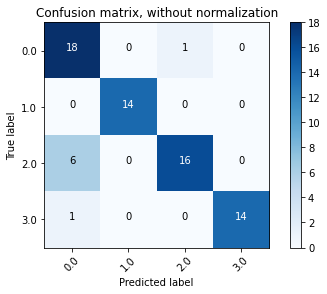

Normalized confusion matrix


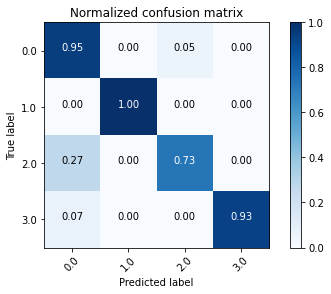

Accuracy: 0.8857142857142857

Classification Report:
              precision    recall  f1-score   support

         0.0       0.72      0.95      0.82        19
         1.0       1.00      1.00      1.00        14
         2.0       0.94      0.73      0.82        22
         3.0       1.00      0.93      0.97        15

    accuracy                           0.89        70
   macro avg       0.92      0.90      0.90        70
weighted avg       0.91      0.89      0.89        70

model: AdaBoost
Confusion matrix, without normalization


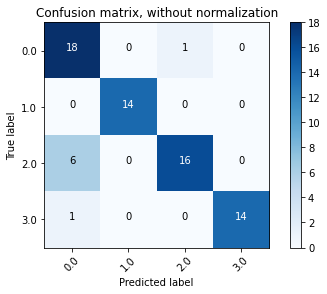

Normalized confusion matrix


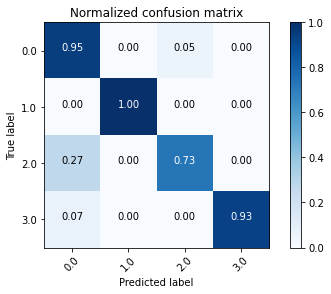

Accuracy: 0.8857142857142857

Classification Report:
              precision    recall  f1-score   support

         0.0       0.72      0.95      0.82        19
         1.0       1.00      1.00      1.00        14
         2.0       0.94      0.73      0.82        22
         3.0       1.00      0.93      0.97        15

    accuracy                           0.89        70
   macro avg       0.92      0.90      0.90        70
weighted avg       0.91      0.89      0.89        70



In [123]:
# evaluate different models

neigh = KNeighborsClassifier(n_neighbors=10)
logist = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000)
RF = RandomForestClassifier(random_state=0)
AdaBoost = AdaBoostClassifier(random_state=0)
# models = [(neigh,'K-NN'),
#         (logist,'Logistic Regression')]
models = [(RF,'RandomForest'),
        (AdaBoost, 'AdaBoost')]
for model, model_name in models:
    print(f"model: {model_name}")
    predictions, labels = evaluate_model(X_train, y_train, neigh)
    plot_confusion_matrix(predictions, labels, class_names)
    report(predictions, labels)

In [86]:
# Evaluate different K values for K-NN
k_range = list(range(26))[1:]

for k in k_range:
    kfold = KFold(n_splits=10, random_state=0, shuffle=True)
    neigh = KNeighborsClassifier(n_neighbors=k)
    cv_results = cross_validate(neigh, X_train, y_train, cv=kfold, scoring=scoring)
    print(f'k = {k}')
    print("acc\t\t\tprecision\t\trecall\t\t\tf1-score")
    print(f"{np.mean(cv_results['test_accuracy'])}\t{np.mean(cv_results['test_precision'])}\t{np.mean(cv_results['test_recall'])}\t{np.mean(cv_results['test_f1_score'])}")
    print("--------------------------")

k = 1
acc			precision		recall			f1-score
0.8997584541062803	0.9114083380387727	0.8997584541062803	0.8993264183481574
--------------------------
k = 2
acc			precision		recall			f1-score
0.8858695652173912	0.8979511732229124	0.8858695652173912	0.8851734014777493
--------------------------
k = 3
acc			precision		recall			f1-score
0.8707729468599034	0.8746502289980551	0.8707729468599034	0.8704689030775987
--------------------------
k = 4
acc			precision		recall			f1-score
0.8997584541062801	0.9173184571735297	0.8997584541062801	0.8985256742050219
--------------------------
k = 5
acc			precision		recall			f1-score
0.9136473429951691	0.9267706176673568	0.9136473429951691	0.9132878795922273
--------------------------
k = 6
acc			precision		recall			f1-score
0.8852657004830918	0.9079441760601181	0.8852657004830918	0.885357301768915
--------------------------
k = 7
acc			precision		recall			f1-score
0.8997584541062801	0.9173184571735297	0.8997584541062801	0.8985256742050219
--------------------

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Pr

k = 23
acc			precision		recall			f1-score
0.4855072463768116	0.4629942036271959	0.4855072463768116	0.3872034654195633
--------------------------
k = 24
acc			precision		recall			f1-score
0.4571256038647343	0.45384615384615384	0.4571256038647343	0.35747339362900005
--------------------------
k = 25
acc			precision		recall			f1-score
0.4432367149758454	0.4464533152033152	0.4432367149758454	0.3478586705467847
--------------------------


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [109]:
# Evaluate different solver for Logistic Regression
solvers = ['newton-cg', 'sag','saga', 'lbfgs']

for solver in solvers:
    kfold = KFold(n_splits=10, random_state=0, shuffle=True)
    logist = LogisticRegression(random_state=0, solver=solver, max_iter=1000)
    cv_results = cross_validate(logist, X_train, y_train, cv=kfold, scoring=scoring)
    print(f'solver = {solver}')
    print("acc\t\t\tprecision\t\trecall\t\t\tf1-score")
    print(f"{np.mean(cv_results['test_accuracy'])}\t{np.mean(cv_results['test_precision'])}\t{np.mean(cv_results['test_recall'])}\t{np.mean(cv_results['test_f1_score'])}")
    print("--------------------------")

solver = newton-cg
acc			precision		recall			f1-score
0.5904500381388254	0.6035811544711989	0.5904500381388254	0.5702284258084843
--------------------------
solver = sag
acc			precision		recall			f1-score
0.5904500381388254	0.6035811544711989	0.5904500381388254	0.5702284258084843
--------------------------
solver = saga
acc			precision		recall			f1-score
0.5904500381388254	0.6035811544711989	0.5904500381388254	0.5702284258084843
--------------------------
solver = lbfgs
acc			precision		recall			f1-score
0.5904500381388254	0.6035811544711989	0.5904500381388254	0.5702284258084843
--------------------------


In [131]:
# Evaluate different max_depth for Random Forest
max_depths = [2, 3, 4, 5, 6]

for max_depth in max_depths:
    kfold = KFold(n_splits=10, random_state=0, shuffle=True)
    RF = RandomForestClassifier(random_state=0, max_depth=max_depth)
    cv_results = cross_validate(RF, X_train, y_train, cv=kfold, scoring=scoring)
    print(f'max_depth = {max_depth}')
    print("acc\tprecision\trecall\tf1-score")
    print(f"{np.mean(cv_results['test_accuracy'])}\t{np.mean(cv_results['test_precision'])}\t{np.mean(cv_results['test_recall'])}\t{np.mean(cv_results['test_f1_score'])}")
    print("--------------------------")

max_depth = 2
acc	precision	recall	f1-score
0.8857142857142856	0.9333333333333332	0.8857142857142856	0.8861224489795918
--------------------------
max_depth = 3
acc	precision	recall	f1-score
0.8857142857142856	0.9333333333333332	0.8857142857142856	0.8861224489795918
--------------------------
max_depth = 4
acc	precision	recall	f1-score
0.8857142857142856	0.9333333333333332	0.8857142857142856	0.8861224489795918
--------------------------
max_depth = 5
acc	precision	recall	f1-score
0.9	0.9357142857142857	0.9	0.8980272108843537
--------------------------
max_depth = 6
acc	precision	recall	f1-score
0.9	0.9357142857142857	0.9	0.8980272108843537
--------------------------


In [136]:
# Evaluate different learning rate for Random Forest
learning_rates = [0.001, 0.005, 0.01 ,0.05, 0.1, 0.5, 1.0]

for learning_rate in learning_rates:
    kfold = KFold(n_splits=10, random_state=0, shuffle=True)
    AdaBoost = AdaBoostClassifier(random_state=0, learning_rate=learning_rate)
    cv_results = cross_validate(AdaBoost, X_train, y_train, cv=kfold, scoring=scoring)
    print(f'learning rate = {learning_rate}')
    print("acc\tprecision\trecall\tf1-score")
    print(f"{np.mean(cv_results['test_accuracy'])}\t{np.mean(cv_results['test_precision'])}\t{np.mean(cv_results['test_recall'])}\t{np.mean(cv_results['test_f1_score'])}")
    print("--------------------------")

learning rate = 0.001
acc	precision	recall	f1-score
0.7142857142857142	0.8923809523809524	0.7142857142857142	0.6691836734693879
--------------------------
learning rate = 0.005
acc	precision	recall	f1-score
0.8571428571428571	0.9328571428571429	0.8571428571428571	0.8434693877551019
--------------------------
learning rate = 0.01
acc	precision	recall	f1-score
0.8857142857142856	0.9357142857142857	0.8857142857142856	0.8761904761904761
--------------------------
learning rate = 0.05
acc	precision	recall	f1-score
0.7285714285714285	0.8519047619047619	0.7285714285714285	0.6834467120181407
--------------------------
learning rate = 0.1
acc	precision	recall	f1-score
0.8	0.887142857142857	0.8	0.7663945578231293
--------------------------
learning rate = 0.5
acc	precision	recall	f1-score
0.7857142857142857	0.8602380952380952	0.7857142857142857	0.7601360544217687
--------------------------
learning rate = 1.0
acc	precision	recall	f1-score
0.7	0.828809523809524	0.7	0.6208163265306121
------------

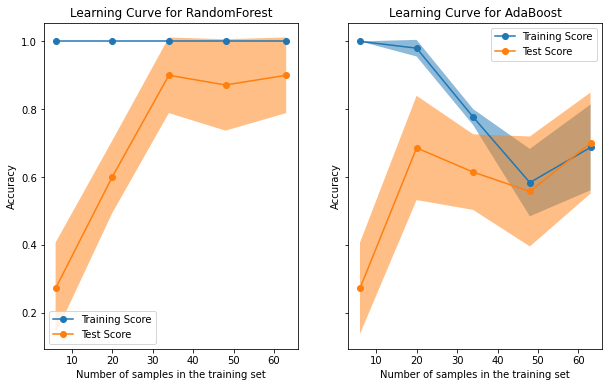

In [124]:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)
common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": KFold(10, shuffle=True, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}
neigh = KNeighborsClassifier(n_neighbors=10)
logist = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000)
RF = RandomForestClassifier(random_state=0)
AdaBoost = AdaBoostClassifier(random_state=0)
models = [(neigh,'K-NN'),
        (logist,'Logistic Regression')]
models = [(RF,'RandomForest'),
        (AdaBoost, 'AdaBoost')]
for ax_idx, (model, model_name) in enumerate(models):
    LearningCurveDisplay.from_estimator(model, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {model_name}")